In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
data_dir = os.path.join(os.getcwd(), "..", "data")

In [3]:
daily_file = os.path.join(data_dir, "transit_daily.csv")
daily = pd.read_csv(daily_file, low_memory=False)

In [4]:
# gets a smaller version for faster troubleshooting
# daily = daily.head(10000)
daily = daily.dropna(axis=0, subset=["service_date", "arrival_time", "deviance"])
daily = daily.sort_values(["service_date", "arrival_time"])

In [5]:
import time
import datetime


def to_timestamp(date_str, sec_num):
    gmtime = time.gmtime(sec_num)
    date_list = date_str.split("/")
    timestamp = pd.Timestamp(
        year=2000 + int(date_list[2]),
        month=int(date_list[0]),
        day=int(date_list[1]),
        hour=gmtime.tm_hour,
        minute=gmtime.tm_min,
        second=gmtime.tm_sec,
    )
    # 60 * 60 * 24 = 86400 (some of the days have more than 24 hours of arrival times somehow...)
    if sec_num > 86400:
        timestamp += datetime.timedelta(days=1)
    return timestamp


daily["timestamp"] = np.vectorize(to_timestamp)(
    daily["service_date"], daily["arrival_time"]
)

# daily = daily.set_index("timestamp")

In [6]:
daily = daily.sort_values(["trip_id", "timestamp"])

In [7]:
daily.deviance = daily.deviance.apply(lambda x: pd.to_timedelta(x).total_seconds())
# moves the labels one stop back, so that the previous stops information in the input for the current stops label

In [8]:
int_types = [
    "trip_id",
    "arrival_time",
    "departure_time",
    "stop_time",
    "door",
    "gtfs_trip_id",
    "gtfs_stop_time_id",
    "stop_id",
    "trip_number",
    "route_number",
    "vehicle_number",
    "deviance",
]
daily[int_types] = daily[int_types].fillna(0).astype("int32")

In [9]:
# import functools


# # http://szudzik.com/ElegantPairing.pdf
# @functools.lru_cache()
# def pairing(a, b):
#     return a * a + a + b if a >= b else a + b * b


# daily["stop_id_pairing"] = np.vectorize(pairing)(
#     daily["stop_id"], daily["stop_id"].shift(1)
# )

In [10]:
daily["secs_stopped"] = daily.departure_time - daily.arrival_time

minutes_per_time_cat = 5
daily["time_cat"] = daily.arrival_time // 60 // minutes_per_time_cat

In [11]:
# need to download the two files from this website to run the model.
# https://transitfeeds.com/p/trimet/43?p=14

gtfs_dir_mar = os.path.join(os.getcwd(), "..", "data", "gtfs_mar_14_2017")
gtfs_dir_feb = os.path.join(os.getcwd(), "..", "data", "gtfs_feb_21_2017")

In [12]:
stop_times_mar = os.path.join(gtfs_dir_mar, "stop_times.txt")
stop_times_feb = os.path.join(gtfs_dir_feb, "stop_times.txt")
stop_times_mar = pd.read_csv(stop_times_mar)
stop_times_feb = pd.read_csv(stop_times_feb)

In [13]:
stop_times = pd.concat([stop_times_feb, stop_times_mar]).reset_index(drop=True)
# print(stop_times.arrival_time)

In [14]:
not_to_take_from_stop_times = [
    #     "arrival_time",
    "continuous_drop_off",
    "continuous_pickup",
    #     "departure_time",
    "drop_off_type",
    "pickup_type",
    "stop_headsign",
    "stop_sequence",
    "timepoint",
]
stop_times = stop_times.drop(axis=1, columns=not_to_take_from_stop_times)

print(sorted(stop_times))
# print(stop_times)

['arrival_time', 'departure_time', 'shape_dist_traveled', 'stop_id', 'trip_id']


In [15]:
daily = daily.reset_index()
print(daily.shape)
daily = daily.drop_duplicates()
print(daily.shape)
daily = daily.merge(stop_times, how="left", on=["trip_id", "stop_id"])
print(daily.shape)
daily = daily.drop_duplicates()
print(daily.shape)
# daily = daily.set_index("timestamp")

(513044, 40)
(513044, 40)
(685732, 43)
(513044, 43)


In [16]:
categories = [
    "trip_number",
    "gtfs_stop_time_id",
    "gtfs_stop_id",
    "gtfs_trip_id",
    "train",
    "trip_id",
    "data_agency",
    "data_source",
    "direction",
    "schedule_status",
    "service_key",
    "stop_id",
    "vehicle_number",
    "route_number",
    "trip_number",
    "time_cat",
    "door",
    #     "stop_id_pairing",
]

# should work from what I understand, but doesn't...
# daily[categories] = daily[categories].astype("category")


def make_categories(make_category, df):
    for category in make_category:
        df[category] = pd.Categorical(df[category])


make_categories(categories, daily)

# hashing stopid-1 ++ stopid might be useful.

In [17]:
# train mileage and pattern distance is based on gps data and has way too many negative values when taking the diff, not useable

"""
sort by trip_id or vechicle number and then timestamp before taking these diffs. 
That's because if you sort just by time your mixing all the busses together.
"""

dist = ["pattern_distance", "train_mileage", "shape_dist_traveled"]
delta_dist = ["delta_" + x for x in dist]

daily[delta_dist] = daily[dist].diff(1)

daily[delta_dist] = np.where(daily[delta_dist] < 0, 0, daily[delta_dist])

In [18]:
daily["avg_speed"] = daily.delta_shape_dist_traveled / (
    daily.arrival_time_x - daily.departure_time_x.shift(1)
)
# daily.arrival_time_x - daily.departure_time_x.shift(1)

In [19]:
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     print(daily.shape_dist_traveled)
# print(daily)
# print(daily.trip_id)
# sorted(daily)

In [20]:
daily.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,513044.0,2.594408e+05,149785.734260,0.000000,1.297218e+05,2.594395e+05,3.891602e+05,518868.00
arrival_time_x,513044.0,5.199940e+04,18867.323383,14485.000000,3.582600e+04,5.263200e+04,6.604800e+04,97492.00
departure_time_x,513044.0,5.201622e+04,18866.984231,14485.000000,3.584900e+04,5.265600e+04,6.606500e+04,97492.00
lift,513044.0,1.339456e-02,0.342069,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,164.00
ons,513044.0,5.855716e-01,1.639262,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,214.00
offs,513044.0,5.796676e-01,1.620620,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,204.00
estimated_load,513044.0,9.554005e+00,9.113888,0.000000,0.000000e+00,8.000000e+00,1.500000e+01,67.00
capacity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
early,513044.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.00
on_time,513044.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.00


In [21]:
empty_cols = [
    "early",
    "on_time",
    "late",
    "location_distance",
    "capacity",
]
daily = daily.drop(axis=1, columns=empty_cols)

# daily.describe().transpose()

In [22]:
# remove all rows with nans, infs, and -infs
# https://stackoverflow.com/a/45745154/6293070

In [23]:
# daily[
#     [
#         "arrival_time_y",
#         "departure_time_y",
#         "arrival_time_x",
#         "departure_time_x",
#         "ons",
#         "offs",
#     ]
# ][:50]

In [24]:
daily['label'] = daily.deviance.shift(-1) # WHICH WAY SHOULD THIS SHIFT???
# daily = daily.dropna(axis=0, subset=["label"]) # not needed because clearing infs and nans below

In [25]:
daily = daily[~daily.isin([np.nan, np.inf, -np.inf]).any(1)]

In [26]:
# print(daily.timestamp[0], daily.timestamp[-1])

In [27]:
used_cols = [
    "direction",
    "door",
    "lift",
    "dwell",
    "ons",
    "offs",
    "maximum_speed",
    "service_key",
    "schedule_status",
    "deviance",
    "secs_stopped",
    "time_cat",
    "stop_id",
#     "delta_shape_dist_traveled",
    "delta_pattern_distance",
    "avg_speed",
    "label",
]
x = daily[used_cols]
x = pd.get_dummies(x)  # turns all categoricals into one hot encoded columns!


label = x.pop("label")

In [28]:
# print(sorted(x))
# print(target.name)
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     print(x.head())
print("number of input features: ", len(sorted(x)))

number of input features:  459


In [29]:
import tensorflow as tf

tf.random.set_seed(1234)

# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

# if batch size is one the net freaks out (maybe traning, maybe testing, either way, it's bad)
batch_size = 50
data_len = len(x)
train = 0.8
val = 0.1
test = 0.1

assert train + val + test == 1

train_size = int(train * data_len)
val_size = int(val * data_len)

dataset = tf.data.Dataset.from_tensor_slices((x.values, label.values))

dataset = dataset.shuffle(data_len)

train_dataset = dataset.take(train_size).batch(batch_size)
val_dataset = dataset.skip(train_size).take(val_size).batch(batch_size)
test_dataset = dataset.skip(train_size).skip(val_size).batch(batch_size)

In [30]:
def get_compiled_model():
    model = tf.keras.Sequential(
        [
            # won't work because we can't normalize the output?
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(500, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            #             tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanSquaredError(
            reduction="auto", name="mean_squared_error"
        ),
        metrics=["accuracy", "mean_absolute_error"],
    )

    return model

In [36]:
model = get_compiled_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=4, restore_best_weights=True)
model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[callback])
# model.fit(train_dataset, epochs = 4)

Epoch 1/20
5474/5474 [==============================] - 44s 8ms/step - loss: 10119.8965 - accuracy: 0.0043 - mean_absolute_error: 43.3876 - val_loss: 8162.9116 - val_accuracy: 0.0037 - val_mean_absolute_error: 43.6489
Epoch 2/20
5474/5474 [==============================] - 43s 8ms/step - loss: 7985.1133 - accuracy: 0.0041 - mean_absolute_error: 40.1443 - val_loss: 35512372.0000 - val_accuracy: 0.0037 - val_mean_absolute_error: 534.6539
Epoch 3/20
5474/5474 [==============================] - 43s 8ms/step - loss: 6469.9072 - accuracy: 0.0043 - mean_absolute_error: 38.1727 - val_loss: 55767.5820 - val_accuracy: 0.0043 - val_mean_absolute_error: 56.2284
Epoch 4/20
5474/5474 [==============================] - 42s 8ms/step - loss: 6036.8569 - accuracy: 0.0041 - mean_absolute_error: 37.0222 - val_loss: 13548.2744 - val_accuracy: 0.0042 - val_mean_absolute_error: 59.1257
Epoch 5/20
5474/5474 [==============================] - 42s 8ms/step - loss: 6125.3818 - accuracy: 0.0042 - mean_absolute_er

In [37]:
model.evaluate(test_dataset)

685/685 [==============================] - 4s 3ms/step - loss: 20930.7578 - accuracy: 0.0046 - mean_absolute_error: 37.2581


[20930.7578125, 0.004618262406438589, 37.258121490478516]

In [38]:
preds = []
labels = []
for data in test_dataset:
    preds.append(model.predict_on_batch(data[0]).flatten())
    labels.append(data[1])

preds = [p.tolist() for p in preds]
labels = [l.numpy().tolist() for l in labels]

# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
def flatten(t):
    return [item for sublist in t for item in sublist]


preds = flatten(preds)
labels = flatten(labels)
assert len(preds) == len(labels)

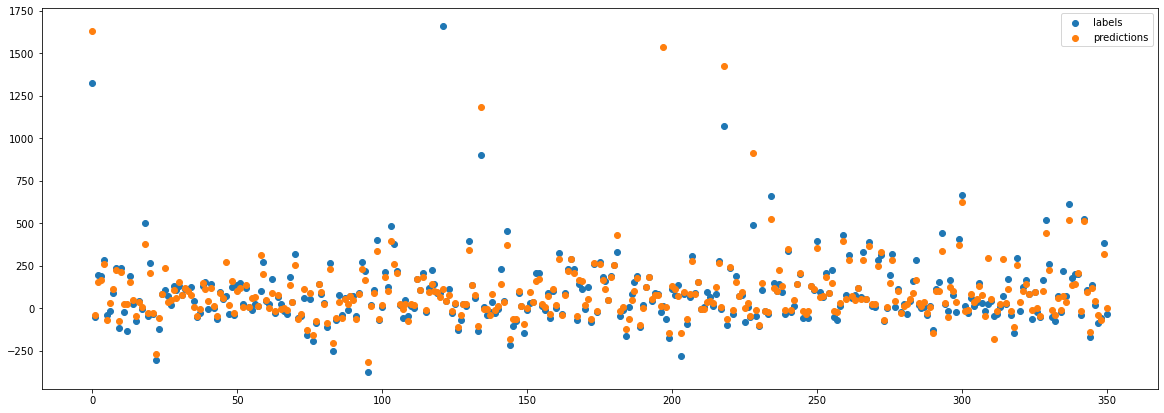

In [39]:
from matplotlib import pyplot as plt

# adjust these numbers to change the width and height of the plot!
plt.rcParams["figure.figsize"] = [20, 7]


def plot(r, l, preds, labels):
    assert len(preds) == len(labels)
    preds = preds[r:l]
    labels = labels[r:l]
    x = list(range(len(preds)))
    plt.scatter(x, labels, label="labels")
    plt.scatter(x, preds, label="predictions")
    plt.legend()
    plt.show()


plot(69, 420, preds, labels)